In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os, glob, copy

import torch
from torchvision import transforms
import torch.nn.functional as F
from torchvision.transforms import InterpolationMode

from train import ViTDDLM, VisionTransformerLM

from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries

In [2]:
vit_model = VisionTransformerLM.load_from_checkpoint(
    checkpoint_path="/data/shared/ACVPR Group 1 2024/vit-cato-1e-no-aug.ckpt")
vit_dd_model = ViTDDLM.load_from_checkpoint(
    checkpoint_path="/data/shared/ACVPR Group 1 2024/vit-dd-cato-1e-ni-aug.ckpt")

IMG_DIR = "../samples/**.jp**"
FACE_DIR = "../face_samples/**.jp**"

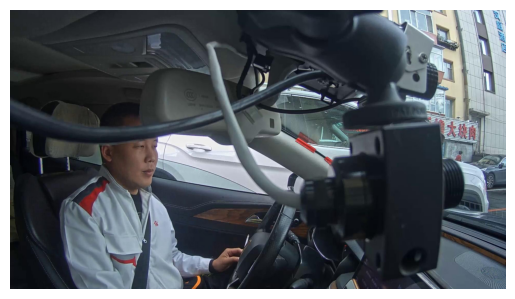

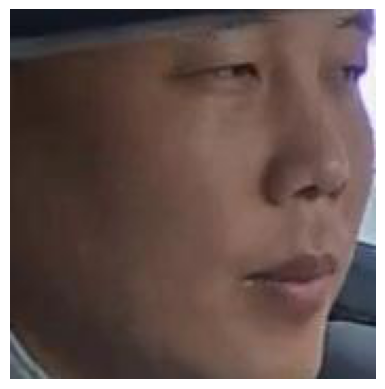

In [3]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            label = path.split('/')[-1].split('.')[0]
            return img.convert('RGB'), label


images = [get_image(img) for img in glob.glob(IMG_DIR)]
faces = [get_image(img) for img in glob.glob(FACE_DIR)]
plt.axis('off')
plt.imshow(images[0][0])
plt.show()
plt.axis('off')
plt.imshow(faces[0][0])
plt.show()

In [4]:
def get_pil_transform(img_size=224):
    transf = transforms.Compose([
        transforms.Resize(img_size, interpolation=InterpolationMode.BICUBIC),
        transforms.CenterCrop(img_size)
    ])

    return transf


def get_preprocess_transform():
    # normalize =
    transf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD)
    ])

    return transf


# Create the transforms
pill_transf = get_pil_transform()
pill_transf_face = get_pil_transform(32)
preprocess_transform = get_preprocess_transform()

In [5]:
def data_labels(explainer, image, fudged_image, segments, num_samples):
    n_features = np.unique(segments).shape[0]
    data = explainer.random_state.randint(0, 2, num_samples * n_features) \
        .reshape((num_samples, n_features))
    data[0, :] = 1
    imgs = []
    for row in data:
        temp = copy.deepcopy(image)
        zeros = np.where(row == 0)[0]
        mask = np.zeros(segments.shape).astype(bool)
        for z in zeros:
            mask[segments == z] = True
        temp[mask] = fudged_image[mask]
        imgs.append(temp)

    return imgs

In [6]:
def batch_predict(batch, model):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in batch), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)

    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()


def make_batch_predict_dd(_face, model):
    def batch_predict_dd(batch):
        model.eval()

        batch = torch.stack(tuple(preprocess_transform(i) for i in batch), dim=0)

        __face = torch.stack(tuple(preprocess_transform(i) for i in _face), dim=0)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        batch = batch.to(device)
        __face = __face.to(device)

        logits = model(batch, __face)
        probs = F.softmax(logits[0], dim=1)
        return probs.detach().cpu().numpy()

    return batch_predict_dd

In [7]:
def explain_image(image, face, model, top_labels=1, hide_color=0, num_samples=500, positive_only=False, num_features=5,
                  batch_size=10):
    explainer = lime_image.LimeImageExplainer()

    if type(model) == ViTDDLM:
        # Generate data augmentation for face image
        random_seed = explainer.random_state.randint(0, high=1000)
        segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=4,
                                                max_dist=200, ratio=0.2,
                                                random_seed=random_seed)

        face = np.array(pill_transf_face(face))
        segments = segmentation_fn(face)
        fudged_image = face.copy()
        fudged_image[:] = hide_color

        face_data = data_labels(explainer, face, fudged_image, segments, batch_size)

        # Create predict function for specific image using the face data
        predict = make_batch_predict_dd(face_data, model)
    else:
        predict = lambda x: batch_predict(x, model)

    explanation = explainer.explain_instance(np.array(pill_transf(image)),
                                             predict,
                                             top_labels=top_labels,
                                             hide_color=hide_color,
                                             num_samples=num_samples,
                                             batch_size=batch_size)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=positive_only,
                                                num_features=num_features, hide_rest=False)
    img_boundary = mark_boundaries(temp / 255.0, mask)
    return img_boundary

  0%|          | 0/500 [00:00<?, ?it/s]

Saving VisionTransformerLM_Normal Driving.png


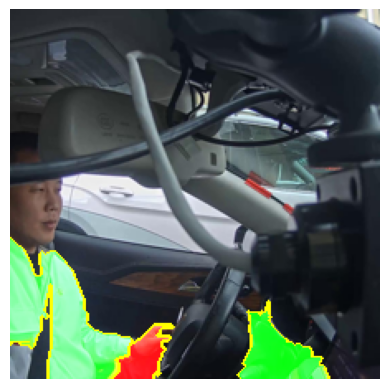

  0%|          | 0/500 [00:00<?, ?it/s]

Saving VisionTransformerLM_Body Movement.png


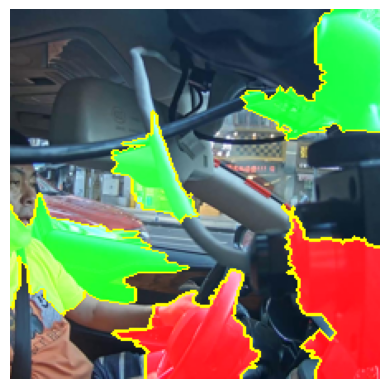

  0%|          | 0/500 [00:00<?, ?it/s]

Saving VisionTransformerLM_Smoking.png


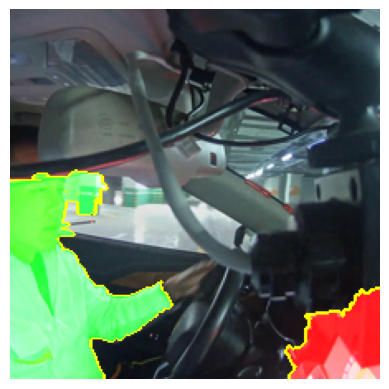

  0%|          | 0/500 [00:00<?, ?it/s]

Saving VisionTransformerLM_Making Phone.png


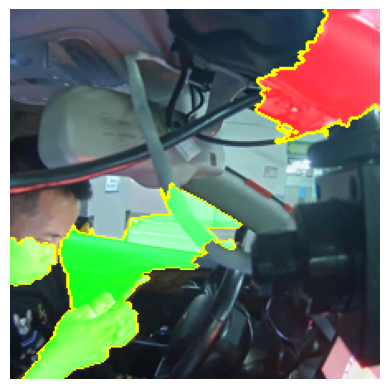

  0%|          | 0/500 [00:00<?, ?it/s]

Saving VisionTransformerLM_Looking Around.png


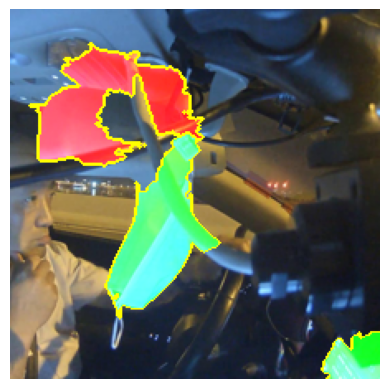

  0%|          | 0/500 [00:00<?, ?it/s]

Saving VisionTransformerLM_Dozing Off.png


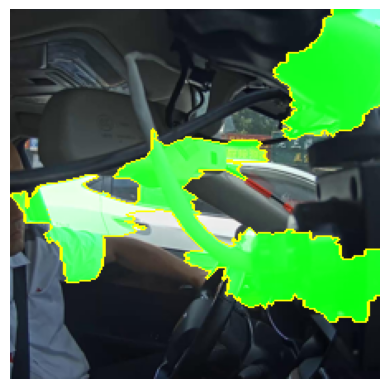

  0%|          | 0/500 [00:00<?, ?it/s]

Saving VisionTransformerLM_Talking.png


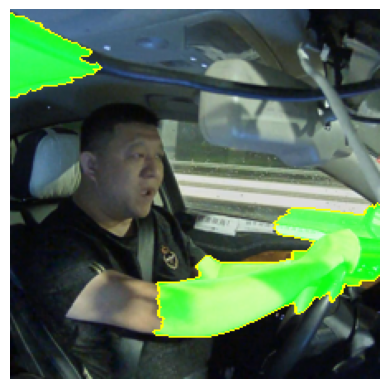

  0%|          | 0/500 [00:00<?, ?it/s]

Saving ViTDDLM_Normal Driving.png


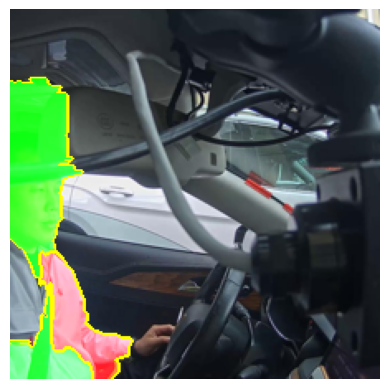

  0%|          | 0/500 [00:00<?, ?it/s]

Saving ViTDDLM_Body Movement.png


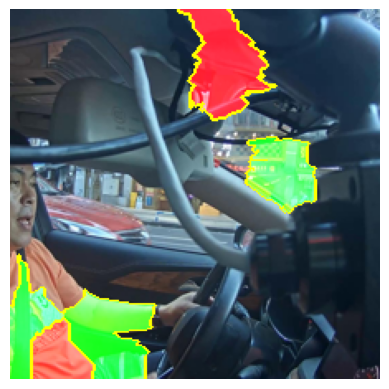

  0%|          | 0/500 [00:00<?, ?it/s]

Saving ViTDDLM_Smoking.png


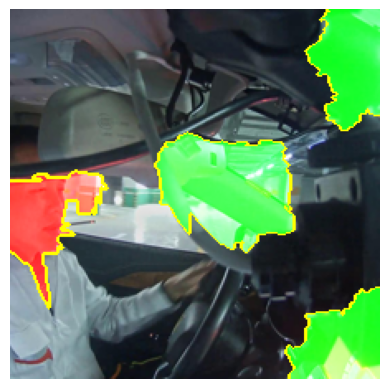

In [ ]:
models = [vit_model, vit_dd_model]

for model in models:
    model_name = model.__class__.__name__
    for i in range(len(images)):
        image_ = images[i][0]
        face_ = faces[i][0]
        label_ = images[i][1]
        plt.figure()  # Start a new figure for each image
        plt.axis('off')
        explained_image = explain_image(image_, face_, model)
        explained_image = Image.fromarray((explained_image * 255).astype(np.uint8))
        explained_image = explained_image.resize((224, 224))
        if explained_image is not None:
            print(f"Saving {model_name}_{label_}.png")
            plt.imshow(explained_image)
            plt.savefig(f"lime_explanations/{model_name}_{label_}.png", transparent=True, pad_inches=0,
                        bbox_inches='tight')
        plt.show()  # Display the current figure